# Yelp Restaurant Image Classifier (Transfer Learning)
* Author: Peerapak Adsavakulchai
* Email: padsavak@uchicago.edu
* Purpose: University of Chicago MSCA 31009 Final Project


### Installation of the Packages
Run if not already installed

In [1]:
!pip install tensorflow --quiet

In [2]:
!pip install -U efficientnet --quiet

In [3]:
!pip install keras-tuner --quiet

### Importing Packages and Dependencies

In [4]:
import json
import itertools
import time
import os
from google.cloud import storage

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt
from kerastuner.tuners import RandomSearch

#Leading Image Classification Models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
import efficientnet.keras as efn

2023-05-09 03:08:55.953125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 03:08:57.309222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-09 03:08:57.309440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [5]:
os.getcwd()

'/home/jupyter'

### GCP Parameters

In [6]:
storage_client = storage.Client()
bucket_name = 'final-project-31009-peerapak-a'
bucket = storage_client.get_bucket(bucket_name)

### Data Processing

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

In [8]:
#Setting up paths to image files

path_train = '/home/jupyter/Data/Train Data/'
path_test = '/home/jupyter/Data/Test Data/'

path_test0 = '/home/jupyter/Data/Test Data/Class 0'  
path_test1 = '/home/jupyter/Data/Test Data/Class 1'
path_test2 = '/home/jupyter/Data/Test Data/Class 2'
path_test3 = '/home/jupyter/Data/Test Data/Class 3'

#### Image Size: 224 x 224

In [9]:
train_generator224 = train_datagen.flow_from_directory(
    path_train, 
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (224, 224)
)


test_generator224 = test_datagen.flow_from_directory(
    path_test,  
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (224, 224))


Found 1359 images belonging to 4 classes.
Found 589 images belonging to 4 classes.


In [10]:
#Checking Image Size
train_generator224.image_shape

(224, 224, 3)

In [11]:
#Checking Image Classes
train_generator224.class_indices

{'Class 0': 0, 'Class 1': 1, 'Class 2': 2, 'Class 3': 3}

#### Image Size: 150 x 150

In [12]:
train_generator150 = train_datagen.flow_from_directory(
    path_train, 
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (150, 150)
)


test_generator150 = test_datagen.flow_from_directory(
    path_test,  
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (150, 150))


Found 1359 images belonging to 4 classes.
Found 589 images belonging to 4 classes.


## Best in Class Models
1. VGG-19 (University of Oxford)
2. Inception (Google)
3. ResNet50
4. EfficientNet (Google)

https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

### 1. Visual Graphics Group (VGG-16)

* The model is sequential in nature and uses lots of filters. 

* At each stage, small 3 * 3 filters are used to reduce the number of parameters 

* All the hidden layers use the ReLU activation function. 

* Number of parameters is 138 Billion

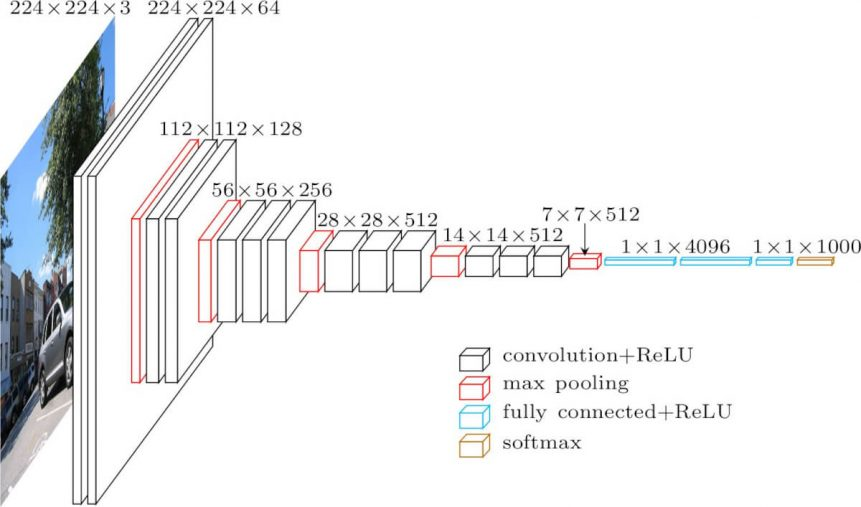


In [13]:
hp = HyperParameters()

In [14]:
def create_VGG16(hp):

    #Loading the base VGG16 Model  ----------------------------------
    base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
        include_top = False, # Leave out the last fully connected layer
        weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False
        
    #Recreating the Dense layers ----------------------------------

    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(base_model.output)
    # Add a fully connected layer with 512 hidden units and ReLU activation
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    # Add a dropout rate of 0.5
    x = tf.keras.layers.Dropout(0.5)(x)
    # Add a final sigmoid layer for classification output
    x = tf.keras.layers.Dense(train_generator224.num_classes, activation = 'softmax')(x)
    
    
    model = tf.keras.models.Model(base_model.input, x)

#Hyper Parameters ------------------------------------------
    
    #hp = HyperParameters()
    lr = hp.Float('learning_rate', 1e-4, 1)
    loss = hp.Choice('loss', ['categorical_crossentropy', 'sparse_categorical_crossentropy'])
    opt = hp.Choice('optimizer', ['adam' ,'rmsprop', 'sgd'])
    
    if opt == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = lr)
        
    elif opt == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate = lr)
        
    else:
        optimizer = keras.optimizers.SGD(learning_rate = lr)

   

    #Model Compiling -----------------------------------------
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics=['accuracy'])
        
    return model
    

In [15]:
tuner = RandomSearch(create_VGG16,
                     objective = 'accuracy',
                     max_trials = 10,
                     executions_per_trial = 10,
                     directory='Transfer_Learning_Training',
                     project_name='VGG_1')

2023-05-09 03:08:59.591851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-09 03:08:59.591931: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-09 03:08:59.591967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cnn-codes): /proc/driver/nvidia/version does not exist
2023-05-09 03:08:59.592335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 5)

In [17]:
tuner.search(train_generator224, callbacks = [stop_early])

Trial 10 Complete [00h 00m 07s]

Best accuracy So Far: 0.45680647194385526
Total elapsed time: 02h 49m 34s
INFO:tensorflow:Oracle triggered exit


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters values
print(f'Best hyperparameters: {best_hps.values}')

Best hyperparameters: {'learning_rate': 0.8950506369162201, 'loss': 'categorical_crossentropy', 'optimizer': 'adam'}


In [19]:
VGG_best = tuner.hypermodel.build(best_hps)

In [20]:
VGG_best.fit_generator(train_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


43/43 [==============================] - 164s 4s/step - loss: 20386.8906 - accuracy: 0.4275


In [21]:
loss, accuracy = VGG_best.evaluate_generator(test_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [22]:
print('VGG Test loss:', loss)
print('VGG Test accuracy:', accuracy)

VGG Test loss: 6.102772235870361
VGG Test accuracy: 0.538200318813324


### 2. Inception

* Introduction of the 1 * 1 convolution operation 

* Number of parameters is 7 million 

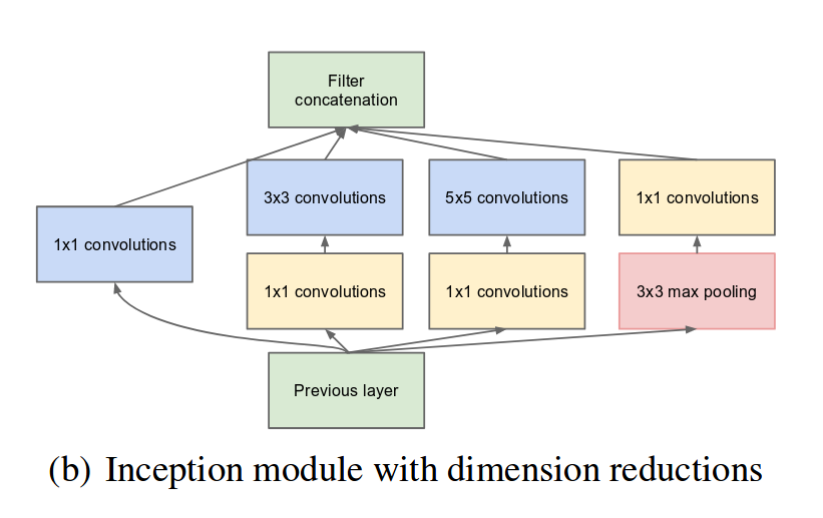


In [23]:
def create_inception(hp):

    #Loading the base VGG16 Model  ----------------------------------
    base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False
        
    #Recreating the Dense layers ----------------------------------

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(train_generator150.num_classes, activation = 'softmax')(x)
    
    
    model = tf.keras.models.Model(base_model.input, x)

#Hyper Parameters ------------------------------------------
    
    #hp = HyperParameters()
    lr = hp.Float('learning_rate', 1e-4, 1)
    loss = hp.Choice('loss', ['categorical_crossentropy', 'sparse_categorical_crossentropy'])
    opt = hp.Choice('optimizer', ['adam' ,'rmsprop', 'sgd'])
    
    if opt == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = lr)
        
    elif opt == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate = lr)
        
    else:
        optimizer = keras.optimizers.SGD(learning_rate = lr)

   

    #Model Compiling -----------------------------------------
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics=['accuracy'])
        
    return model
    

In [24]:
tuner2 = RandomSearch(create_inception,
                     objective = 'accuracy',
                     max_trials = 10,
                     executions_per_trial = 10,
                     directory='Transfer_Learning_Training',
                     project_name='Inception_1')

In [25]:
tuner2.search(train_generator150, callbacks = [stop_early])

Trial 10 Complete [00h 05m 53s]
accuracy: 0.45033113062381747

Best accuracy So Far: 0.49852833449840545
Total elapsed time: 00h 41m 35s
INFO:tensorflow:Oracle triggered exit


In [26]:
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters values
print(f'Best hyperparameters: {best_hps2.values}')

Best hyperparameters: {'learning_rate': 0.43040562652317355, 'loss': 'categorical_crossentropy', 'optimizer': 'sgd'}


In [27]:
Inception_best = tuner2.hypermodel.build(best_hps2)

In [28]:
Inception_best.fit_generator(train_generator150)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


43/43 [==============================] - 31s 612ms/step - loss: 4529.3647 - accuracy: 0.4753


In [29]:
loss, accuracy = Inception_best.evaluate_generator(test_generator150)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [30]:
print('Inception Test loss:', loss)
print('Inception Test accuracy:', accuracy)

Inception Test loss: 1.091770052909851
Inception Test accuracy: 0.5415959358215332


### 3. ResNet50

* Improvement on Inception to avoid poor accuracy as the model went on to become deeper

* Start with a single Convolutional layer and Max Pooling

* 4 subsequent layers that are similar with varying filter sizes (all of them using 3 * 3 convolution operation) 

* After every 2 convolutions, there is a bypassing/skipping of the layer in-between 
    - These skipped connections are called ‘identity shortcut connections” and uses what is called residual blocks

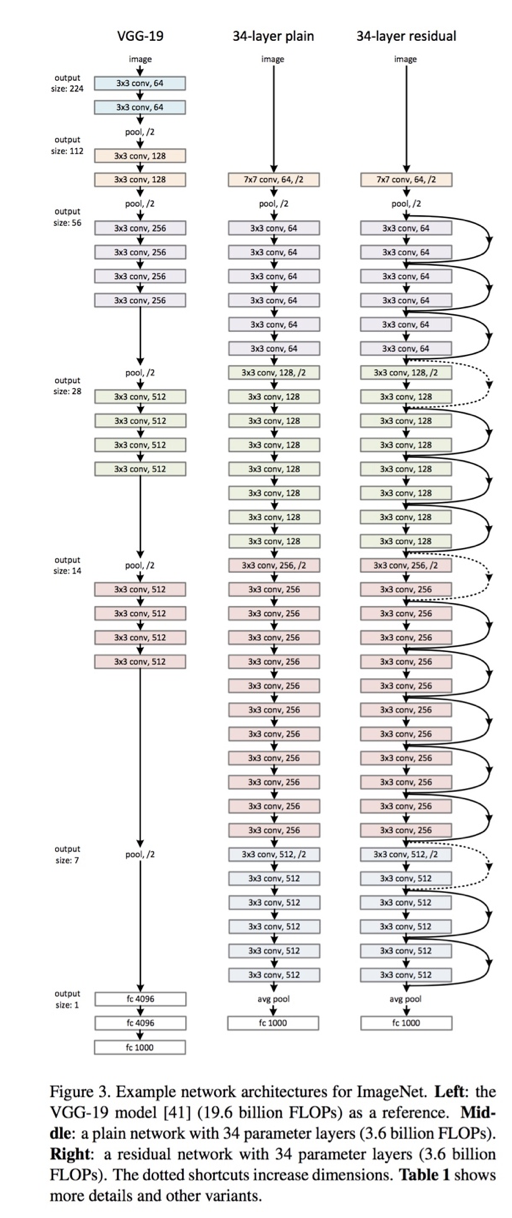


In [31]:
def create_restNet(hp):

    #Loading the base VGG16 Model  ----------------------------------
    base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

    for layer in base_model.layers:
        layer.trainable = False
        
    #Recreating the Dense layers ----------------------------------
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(train_generator224.num_classes, activation = 'softmax')(x)
    
    
    model = tf.keras.models.Model(base_model.input, x)

#Hyper Parameters ------------------------------------------
    
    #hp = HyperParameters()
    lr = hp.Float('learning_rate', 1e-4, 1)
    loss = hp.Choice('loss', ['categorical_crossentropy', 'sparse_categorical_crossentropy'])
    opt = hp.Choice('optimizer', ['adam' ,'rmsprop', 'sgd'])
    
    if opt == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = lr)
        
    elif opt == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate = lr)
        
    else:
        optimizer = keras.optimizers.SGD(learning_rate = lr)

   

    #Model Compiling -----------------------------------------
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics=['accuracy'])
        
    return model
    

In [32]:
tuner3 = RandomSearch(create_restNet,
                     objective = 'accuracy',
                     max_trials = 10,
                     executions_per_trial = 10,
                     directory='Transfer_Learning_Training',
                     project_name='RestNet_1')

In [33]:
tuner3.search(train_generator224, callbacks = [stop_early])

Trial 10 Complete [00h 14m 09s]
accuracy: 0.4147902876138687

Best accuracy So Far: 0.45849889814853667
Total elapsed time: 01h 20m 10s
INFO:tensorflow:Oracle triggered exit


In [34]:
best_hps3 = tuner3.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters values
print(f'Best hyperparameters: {best_hps3.values}')

Best hyperparameters: {'learning_rate': 0.6255631806623757, 'loss': 'categorical_crossentropy', 'optimizer': 'sgd'}


In [35]:
RestNet_best = tuner3.hypermodel.build(best_hps3)

In [36]:
RestNet_best.fit_generator(train_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


43/43 [==============================] - 68s 1s/step - loss: 51225.2227 - accuracy: 0.4422


In [37]:
loss, accuracy = RestNet_best.evaluate_generator(test_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [38]:
print('RestNet50 Test loss:', loss)
print('RestNet50 Test accuracy:', accuracy)

RestNet50 Test loss: 1.0772937536239624
RestNet50 Test accuracy: 0.5415959358215332


### 4. EfficientNet

* From Google 

* New Scaling method called Compound Scaling
    - Uniform dimension scalling

* Proposed Compound Scaling coefficients:
    - Depth = 1.20
    - Width = 1.10
    - Resolution = 1.15
    
* MBConv stands for mobile inverted bottleneck Convolution

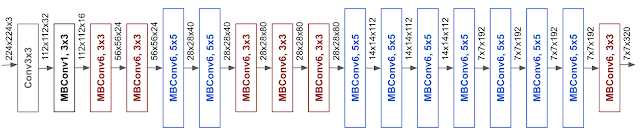


In [39]:
def create_efn(hp):

    #Loading the base VGG16 Model  ----------------------------------
    base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

    for layer in base_model.layers:
        layer.trainable = False
        
    #Recreating the Dense layers ----------------------------------
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(train_generator224.num_classes, activation = 'softmax')(x)
    
    
    model = tf.keras.models.Model(base_model.input, x)

#Hyper Parameters ------------------------------------------
    
    #hp = HyperParameters()
    lr = hp.Float('learning_rate', 1e-4, 1)
    loss = hp.Choice('loss', ['categorical_crossentropy', 'sparse_categorical_crossentropy'])
    opt = hp.Choice('optimizer', ['adam' ,'rmsprop', 'sgd'])
    
    if opt == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = lr)
        
    elif opt == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate = lr)
        
    else:
        optimizer = keras.optimizers.SGD(learning_rate = lr)

   

    #Model Compiling -----------------------------------------
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics=['accuracy'])
        
    return model
    

In [42]:
tuner4 = RandomSearch(create_efn,
                     objective = 'accuracy',
                     max_trials = 10,
                     executions_per_trial = 10,
                     directory='Transfer_Learning_Training',
                     project_name='efn_1')

INFO:tensorflow:Reloading Tuner from Transfer_Learning_Training/efn_1/tuner0.json


In [52]:
tuner4.search(train_generator224, callbacks = [stop_early])

INFO:tensorflow:Oracle triggered exit


In [53]:
best_hps4 = tuner4.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters values
print(f'Best hyperparameters: {best_hps4.values}')

Best hyperparameters: {'learning_rate': 0.14611674948884185, 'loss': 'categorical_crossentropy', 'optimizer': 'rmsprop'}


In [54]:
efn_best = tuner4.hypermodel.build(best_hps4)

In [56]:
efn_best.fit_generator(train_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


43/43 [==============================] - 51s 979ms/step - loss: 17538.6348 - accuracy: 0.4901


In [62]:
loss, accuracy = efn_best.evaluate_generator(test_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [63]:
print('efn Test loss:', loss)
print('efn Test accuracy:', accuracy)

efn Test loss: 3643.935546875
efn Test accuracy: 0.5551782846450806


## Saving Best Performing Models for Later Use

In [64]:
path_model_save = '/home/jupyter/Best Model/'

In [65]:
VGG_best.save(path_model_save + "VGG.h5")
Inception_best.save(path_model_save + "Inception.h5")
RestNet_best.save(path_model_save + "RestNet.h5")
efn_best.save(path_model_save + "EFN.h5")

## Loading Models 
Use when reloading this worksheet after closing out GCP Instance

In [66]:
VGG_load = tf.keras.models.load_model(path_model_save + "VGG.h5")
Inception_load = tf.keras.models.load_model(path_model_save + "Inception.h5")
RestNet_load = tf.keras.models.load_model(path_model_save + "RestNet.h5")
efn_load = tf.keras.models.load_model(path_model_save + "EFN.h5")
                                                                 

In [70]:
efn_load.fit_generator(train_generator224)
loss, accuracy = efn_load.evaluate_generator(test_generator224)
print('efn Test loss:', loss)
print('efn Test accuracy:', accuracy)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


43/43 [==============================] - 41s 950ms/step - loss: 4128.1113 - accuracy: 0.6483


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


efn Test loss: 10374.3203125
efn Test accuracy: 0.5636672377586365


## Re-training Loaded Models

In [68]:
VGG_load.fit_generator(train_generator224)
Inception_load.fit_generator(train_generator150)
RestNet_load.fit_generator(train_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


43/43 [==============================] - 164s 4s/step - loss: 111.3054 - accuracy: 0.5232


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


43/43 [==============================] - 29s 609ms/step - loss: 1.6875 - accuracy: 0.5305


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


43/43 [==============================] - 66s 1s/step - loss: 1.2750 - accuracy: 0.5224


In [72]:
loss_VGG, accuracy_VGG = VGG_load.evaluate_generator(test_generator224)
loss_Incep, accuracy_Incep = Inception_load.evaluate_generator(test_generator150)
loss_Res, accuracy_Res = RestNet_load.evaluate_generator(test_generator224)
loss_efn, accuracy_efn = efn_load.evaluate_generator(test_generator224)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  aft

In [75]:
print(f'VGG: loss = {loss_VGG}, accuracy = {accuracy_VGG}')
print(f'Inception: loss = {loss_Incep}, accuracy = {accuracy_Incep}')
print(f'RestNet: loss = {loss_Res}, accuracy = {accuracy_Res}')
print(f'EFN: loss = {loss_efn}, accuracy = {accuracy_efn}')

VGG: loss = 2.84547758102417, accuracy = 0.31578946113586426
Inception: loss = 2.047633647918701, accuracy = 0.5415959358215332
RestNet: loss = 1.1075433492660522, accuracy = 0.5415959358215332
EFN: loss = 10374.318359375, accuracy = 0.5636672377586365


## Result Analysis 